In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import Ridge

In [23]:
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 13,6

## Kobe Bryant  shot selection

Cсылка на соревнование: https://www.kaggle.com/c/kobe-bryant-shot-selection

Goal: Fun and education

Using 20 years of data on Kobe's swishes and misses, can you predict which shots will find the bottom of the net? This competition is well suited for practicing classification basics, feature engineering, and time series analysis. Practice got Kobe an eight-figure contract and 5 championship rings. What will it get you?

This data contains the location and circumstances of every field goal attempted by Kobe Bryant took during his 20-year career. Your task is to predict whether the basket went in (shot_made_flag).

We have removed 5000 of the shot_made_flags (represented as missing values in the csv file). These are the test set shots for which you must submit a prediction. You are provided a sample submission file with the correct shot_ids needed for a valid prediction.

In [210]:
data = pd.read_csv('Kobe.csv')

In [211]:
data.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


**Задания:**

1. Провести анализ данных. Много хороших примеров анализа можно посмотреть здесь https://www.kaggle.com/c/kobe-bryant-shot-selection/kernels
2. Подготовить фичи для обучения модели - нагенерить признаков, обработать пропущенные значения, проверить на возможные выбросы, обработать категориальные признаки и др.
3. Обучить линейную модель, Lasso, Ridge (с встроеной регуляризацией) на тех же признаках - построить сравнительную таблицу или график коэффициентов, сделать заключения о том, как меняется величина коэффициентов, какие зануляются. 

**Дополнительно**
4. Сравнить результаты на тестовом наборе данных - сделать train_test_split в самом начале, подготовить переменные, сравнить результаты работы классификаторов (те же 3), метрика ROC AUC
5. Построить PCA на подготовленных признаках, посмотреть, какие компоненты составляют наибольшую часть дисперсии целевой переменной

In [212]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   action_type         30697 non-null  object 
 1   combined_shot_type  30697 non-null  object 
 2   game_event_id       30697 non-null  int64  
 3   game_id             30697 non-null  int64  
 4   lat                 30697 non-null  float64
 5   loc_x               30697 non-null  int64  
 6   loc_y               30697 non-null  int64  
 7   lon                 30697 non-null  float64
 8   minutes_remaining   30697 non-null  int64  
 9   period              30697 non-null  int64  
 10  playoffs            30697 non-null  int64  
 11  season              30697 non-null  object 
 12  seconds_remaining   30697 non-null  int64  
 13  shot_distance       30697 non-null  int64  
 14  shot_made_flag      25697 non-null  float64
 15  shot_type           30697 non-null  object 
 16  shot

In [213]:
data.describe()

,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,seconds_remaining,shot_distance,shot_made_flag,team_id,shot_id
count,30697.000000,3.069700e+04,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,25697.000000,3.069700e+04,30697.000000
mean,249.190800,2.476407e+07,33.953192,7.110499,91.107535,-118.262690,4.885624,2.519432,0.146562,28.365085,13.437437,0.446161,1.610613e+09,15349.000000
std,150.003712,7.755175e+06,0.087791,110.124578,87.791361,0.110125,3.449897,1.153665,0.353674,17.478949,9.374189,0.497103,0.000000e+00,8861.604943
min,2.000000,2.000001e+07,33.253300,-250.000000,-44.000000,-118.519800,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.610613e+09,1.000000
25%,110.000000,2.050008e+07,33.884300,-68.000000,4.000000,-118.337800,2.000000,1.000000,0.000000,13.000000,5.000000,0.000000,1.610613e+09,7675.000000
50%,253.000000,2.090035e+07,33.970300,0.000000,74.000000,-118.269800,5.000000,3.000000,0.000000,28.000000,15.000000,0.000000,1.610613e+09,15349.000000
75%,368.000000,2.960047e+07,34.040300,95.000000,160.000000,-118.174800,8.000000,3.000000,0.000000,43.000000,21.000000,1.000000,1.610613e+09,23023.000000
max,659.000000,4.990009e+07,34.088300,248.000000,791.000000,-118.021800,11.000000,7.000000,1.000000,59.000000,79.000000,1.000000,1.610613e+09,30697.000000


In [214]:
black_list =['game_event_id','game_id','team_id','shot_id','team_name'] 
continus =['lat','loc_x','loc_y','lon','minutes_remaining','period', 'playoffs','seconds_remaining','shot_distance']
categoricals=['action_type','combined_shot_type','season','shot_type','shot_zone_area','shot_zone_basic','shot_zone_range','matchup','opponent']
target= 'shot_made_flag'

In [215]:
#посчитаем количество категорий
total=0
for cat in categoricals:
    total+=len(data[cat].unique())
    print(cat, len(data[cat].unique()))
print ('total:', total)

action_type 57
combined_shot_type 6
season 20
shot_type 2
shot_zone_area 6
shot_zone_basic 7
shot_zone_range 5
matchup 74
opponent 33
total: 210


In [216]:
# удалим строки c пустыми значениями
data = data.dropna(subset=['shot_made_flag'])
data.shape

(25697, 25)

<AxesSubplot:>

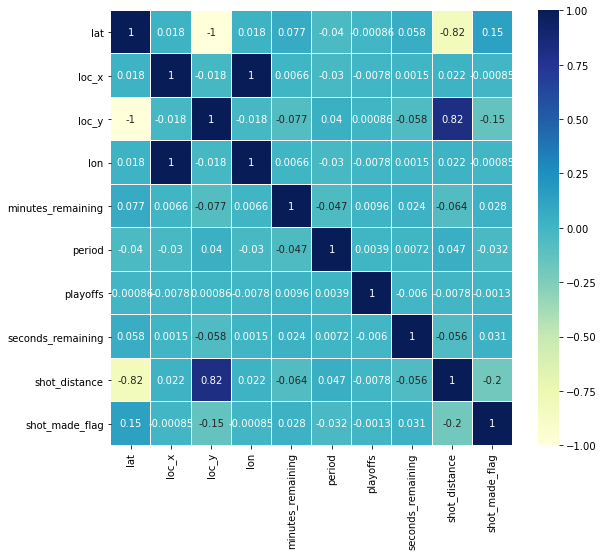

In [217]:
corr= data.drop(['game_event_id','game_id','team_id','shot_id','team_name'], axis=1).corr()
import seaborn as sns
f, ax = plt.subplots(figsize =(9, 8))
correlation = corr
sns.heatmap(correlation, ax = ax, cmap ="YlGnBu", linewidths = 0.1, annot=True)

In [218]:
continus =['lon','minutes_remaining','period', 'playoffs','seconds_remaining','shot_distance']#удалим сильно скоррелированные переменные
categoricals=['combined_shot_type','shot_type','shot_zone_area','shot_zone_basic','shot_zone_range']

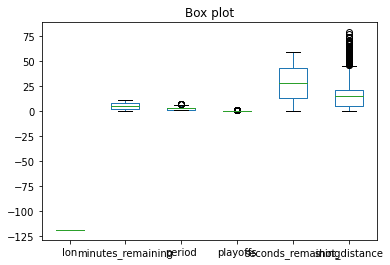

In [194]:
data[continus].plot(kind='box',title='Box plot');

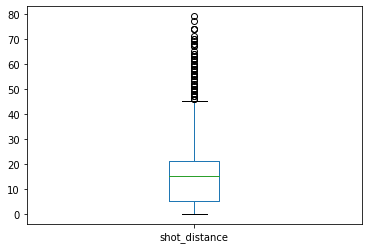

In [195]:
#sns.boxplot(data['shot_distance'])
_, bp = data.shot_distance.plot.box(return_type='both')

In [196]:
outliers = [flier.get_ydata() for flier in bp["fliers"]][0]
data[data.shot_distance.isin(outliers)]

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
177,Jump Shot,Jump Shot,212,20000124,33.5673,47,477,-118.2228,0,2,...,3PT Field Goal,Back Court(BC),Backcourt,Back Court Shot,1610612747,Los Angeles Lakers,2000-11-16,LAL @ SAC,SAC,178
322,Jump Shot,Jump Shot,115,20000222,33.5783,-150,466,-118.4198,0,1,...,3PT Field Goal,Back Court(BC),Backcourt,Back Court Shot,1610612747,Los Angeles Lakers,2000-11-30,LAL @ SEA,SEA,323
585,Jump Shot,Jump Shot,114,20000347,33.4243,100,620,-118.1698,0,1,...,3PT Field Goal,Back Court(BC),Backcourt,Back Court Shot,1610612747,Los Angeles Lakers,2000-12-17,LAL @ TOR,TOR,586
1073,Jump Shot,Jump Shot,246,20000702,33.3483,106,696,-118.1638,0,2,...,3PT Field Goal,Back Court(BC),Backcourt,Back Court Shot,1610612747,Los Angeles Lakers,2001-02-07,LAL vs. PHX,PHX,1074
1605,Jump Shot,Jump Shot,400,20100083,33.4563,-145,588,-118.4148,0,3,...,3PT Field Goal,Back Court(BC),Backcourt,Back Court Shot,1610612747,Los Angeles Lakers,2001-11-09,LAL vs. MEM,MEM,1606
2523,Jump Shot,Jump Shot,337,20100741,33.4833,60,561,-118.2098,0,3,...,3PT Field Goal,Back Court(BC),Backcourt,Back Court Shot,1610612747,Los Angeles Lakers,2002-02-17,LAL @ POR,POR,2524
3211,Jump Shot,Jump Shot,113,20200069,33.4953,64,549,-118.2058,0,1,...,3PT Field Goal,Back Court(BC),Backcourt,Back Court Shot,1610612747,Los Angeles Lakers,2002-11-07,LAL @ BOS,BOS,3212
3553,Jump Shot,Jump Shot,349,20200254,33.5433,-118,501,-118.3878,0,3,...,3PT Field Goal,Back Court(BC),Backcourt,Back Court Shot,1610612747,Los Angeles Lakers,2002-12-03,LAL vs. MEM,MEM,3554
3715,Jump Shot,Jump Shot,339,20200372,33.3933,-207,651,-118.4768,0,3,...,3PT Field Goal,Back Court(BC),Backcourt,Back Court Shot,1610612747,Los Angeles Lakers,2002-12-20,LAL @ PHI,PHI,3716
4077,Jump Shot,Jump Shot,110,20200667,33.5773,-69,467,-118.3388,0,1,...,3PT Field Goal,Back Court(BC),Backcourt,Back Court Shot,1610612747,Los Angeles Lakers,2003-01-31,LAL @ SAC,SAC,4078


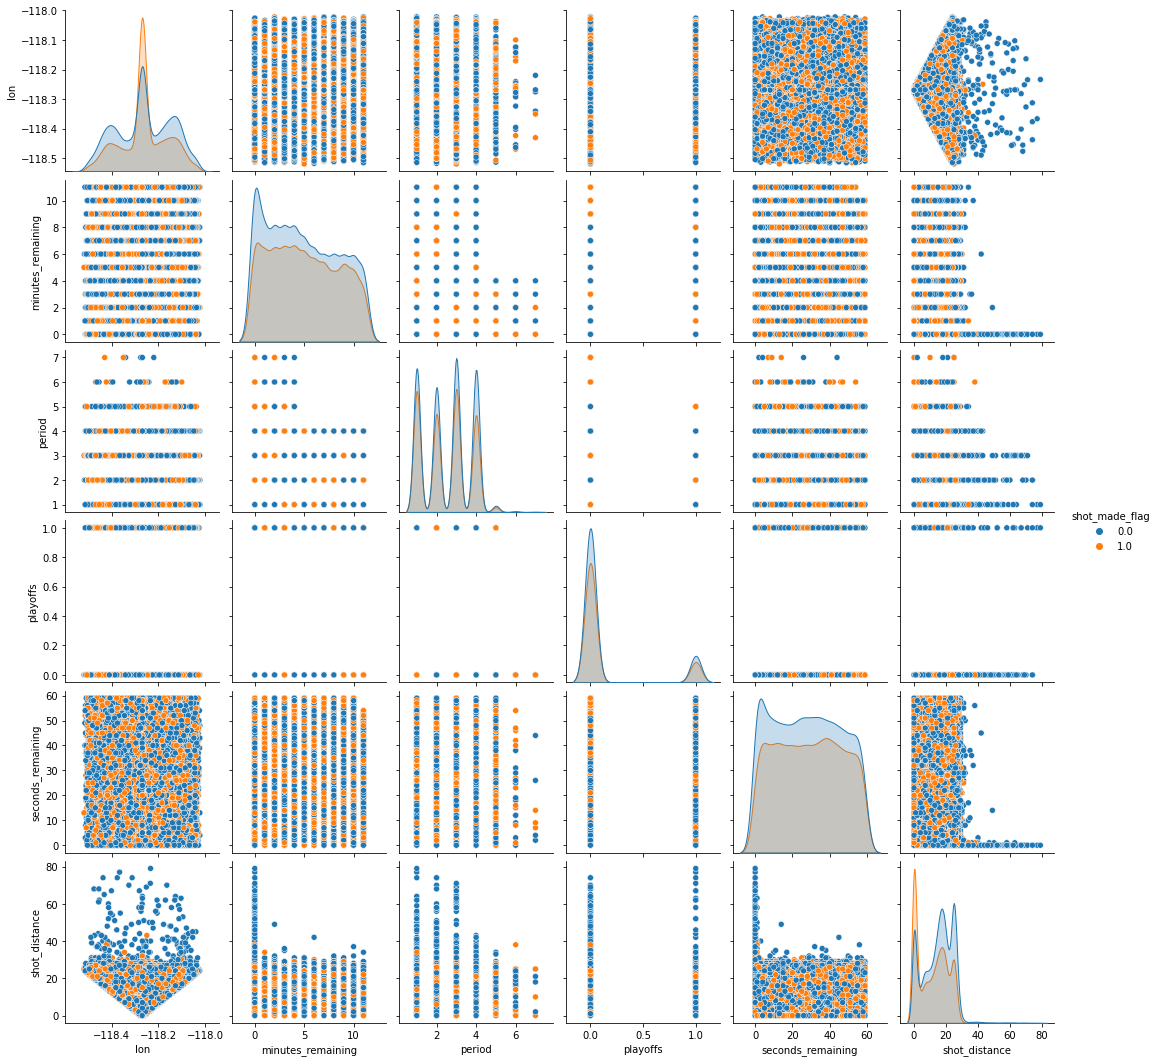

In [219]:
_=sns.pairplot(data=data, vars =continus, hue = target)

In [220]:
y= data[target]
y.shape

(25697,)

In [221]:
y.value_counts() #выборка сбалансировано

0.0    14232
1.0    11465
Name: shot_made_flag, dtype: int64

In [227]:
d = preprocessing.normalize(data1[continus], axis=0)
scaled_X = pd.DataFrame(d, columns=continus)
scaled_X.shape

(25697, 6)

In [225]:
data[categoricals].shape

(25697, 5)

In [226]:
data.shape

(25697, 25)

In [203]:
#X=pd.concat([data[continus], pd.get_dummies(data[categoricals])], axis=1)
X = pd.concat([scaled_X, pd.get_dummies(data[categoricals])], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29881 entries, 0 to 30696
Data columns (total 32 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   lon                                    25697 non-null  float64
 1   minutes_remaining                      25697 non-null  float64
 2   period                                 25697 non-null  float64
 3   playoffs                               25697 non-null  float64
 4   seconds_remaining                      25697 non-null  float64
 5   shot_distance                          25697 non-null  float64
 6   combined_shot_type_Bank Shot           25697 non-null  float64
 7   combined_shot_type_Dunk                25697 non-null  float64
 8   combined_shot_type_Hook Shot           25697 non-null  float64
 9   combined_shot_type_Jump Shot           25697 non-null  float64
 10  combined_shot_type_Layup               25697 non-null  float64
 11  co

In [189]:
X_train, X_test, y_train,y_test=train_test_split(X,y, test_size=0.2,random_state=42)
X_train.shape, y_train.shape

ValueError: Found input variables with inconsistent numbers of samples: [29881, 25697]

In [190]:
# обучим модель методом Lasso 
clf = linear_model.Lasso(alpha=0, random_state=43)
clf.fit(X_train, y_train)

<ipython-input-190-4e388253faec>:3: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  clf.fit(X_train, y_train)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').